In [106]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.proportion as proportion
import math

dataset info: https://nannxiao.github.io/sustain//Progresa-Econometrics-&-Causal-Impact-Analysis.html

You can find a list of column names and meanings here.


On questions of bias, I believe that the experts that design this study accounted for as much as possible.  Without prying too much into the details of the surveys, it is possible that there may be a few areas of concern such as the stakes involved for the government officials and the researchers involved, who had a vested interest in good results.  One issue to point out is that this is only a sample and not the complete dataset.  Addtional years, while more complicated, could've given more time to expose the eligible citizens to the program and made the results more robust.  Again, I think the researchers for this project did a great job; there is a reason this study is famous in the field.  For the purposes of a t test, and looking at village level data, more village characteristics would've been helpful like a rough population estimate to give the village some scale.  Avoiding the many attendance null values would've been nice as well for larger samples in smaller villages. Naturally, the continuation/reintroduction of this program as Oportunidades on a larger scale offers opportunities to make a similar study more relevant to the larger Mexican population.

In [107]:
df = pd.read_csv('https://raw.githubusercontent.com/VaisakhiMishra/Progressa-Analysis-using-Regression-Methods/master/progresa_sample.csv')

In [108]:
df.head()

,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,hohedu,hohwag,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97
0,97,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,1,7,1.0
1,98,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,14,163,1,7,1.0
2,97,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,12,163,2,6,1.0
3,98,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,13,163,2,6,1.0
4,97,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,...,6,0.0,583.0,1.0,35.0,8,163,3,2,1.0


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77250 entries, 0 to 77249
Data columns (total 21 columns):
year             77250 non-null int64
sex              77226 non-null float64
indig            76950 non-null float64
dist_sec         77250 non-null float64
sc               68797 non-null float64
grc              70701 non-null float64
fam_n            77250 non-null int64
min_dist         77250 non-null float64
dist_cap         77250 non-null float64
poor             77250 non-null object
progresa         77250 non-null object
hohedu           77250 non-null int64
hohwag           77250 non-null float64
welfare_index    77040 non-null float64
hohsex           77230 non-null float64
hohage           77240 non-null float64
age              77250 non-null int64
village          77250 non-null int64
folnum           77250 non-null int64
grc97            77250 non-null int64
sc97             73378 non-null float64
dtypes: float64(12), int64(7), object(2)
memory usage: 12.4+ MB


In [110]:
df.isnull().sum()

year                0
sex                24
indig             300
dist_sec            0
sc               8453
grc              6549
fam_n               0
min_dist            0
dist_cap            0
poor                0
progresa            0
hohedu              0
hohwag              0
welfare_index     210
hohsex             20
hohage             10
age                 0
village             0
folnum              0
grc97               0
sc97             3872
dtype: int64

In [111]:
#explore treatment and control size
df['progresa'][df['progresa']!='basal'].value_counts()

0    29690
Name: progresa, dtype: int64

In [112]:
df['progresa'][df['progresa']=='basal'].value_counts()

basal    47560
Name: progresa, dtype: int64

In [113]:
df['year'].value_counts()

98    38625
97    38625
Name: year, dtype: int64

In [114]:
df['treatment'] = df['progresa']=='basal'
df['poor2'] =df['poor'] == 'pobre'

Explore difference between control variables in 97 for individuals in treatment and control groups:

In [115]:
control_pop_97 = df[(df['treatment']==False) & (df['year']==97)]
treatment_pop_97 = df[(df['treatment']==True) & (df['year']==97)]
control_pop_98 = df[(df['treatment']==False) & (df['year']==98)]
treatment_pop_98 = df[(df['treatment']==True) & (df['year']==98)]

In [116]:
df['sc'][df['treatment']==False].count()

26352

In [117]:
df['sc'][df['treatment']==True].count()

42445

In [118]:
control_pop_97.count()

year             14845
sex              14840
indig            14796
dist_sec         14845
sc               14078
grc              14845
fam_n            14845
min_dist         14845
dist_cap         14845
poor             14845
progresa         14845
hohedu           14845
hohwag           14845
welfare_index    14751
hohsex           14843
hohage           14844
age              14845
village          14845
folnum           14845
grc97            14845
sc97             14078
treatment        14845
poor2            14845
dtype: int64

In [119]:
control_pop_98.count()

year             14845
sex              14840
indig            14796
dist_sec         14845
sc               12274
grc              12270
fam_n            14845
min_dist         14845
dist_cap         14845
poor             14845
progresa         14845
hohedu           14845
hohwag           14845
welfare_index    14751
hohsex           14843
hohage           14844
age              14845
village          14845
folnum           14845
grc97            14845
sc97             14078
treatment        14845
poor2            14845
dtype: int64

While not accurate for non normal testing, confidence intervals do help give a reference point to the strength of the difference

In [120]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return ci_lower,ci_upper

Remove extra columns:

In [121]:
columns = list(df.columns.values)
columns.remove('progresa')
columns.remove('poor')
columns.remove('welfare_index')
columns.remove('sc97')
columns.remove('village')
columns.remove('year')
columns.remove('treatment')
columns.remove('folnum')
df_columns_97 = pd.DataFrame(index=columns)

Generate additional summary statistics:

In [122]:
for column in columns:
    df_columns_97.at[column, 'control shapiro stat'] = stats.shapiro(control_pop_97[column][control_pop_97[column].notna()==True])[0]
    df_columns_97.at[column, 'treatment shapiro stat'] = stats.shapiro(treatment_pop_97[column][treatment_pop_97[column].notna()==True])[0]
    df_columns_97.at[column, 'control mean'] = control_pop_97[column][control_pop_97[column].notna()==True].mean()
    df_columns_97.at[column, 'treatment mean'] = treatment_pop_97[column][treatment_pop_97[column].notna()==True].mean()
    df_columns_97.at[column, 'ttest stat'] = stats.ttest_ind(treatment_pop_97[column][treatment_pop_97[column].notna()==True],control_pop_97[column][control_pop_97[column].notna()==True])[0]
    df_columns_97.at[column, 'ttest p-value'] = stats.ttest_ind(treatment_pop_97[column][treatment_pop_97[column].notna()==True],control_pop_97[column][control_pop_97[column].notna()==True])[1]
    df_columns_97.at[column, 'low confidence interval'] = get_95_ci(treatment_pop_97[column][treatment_pop_97[column].notna()==True],control_pop_97[column][control_pop_97[column].notna()==True])[0]
    df_columns_97.at[column, 'high confidence interval'] = get_95_ci(treatment_pop_97[column][treatment_pop_97[column].notna()==True],control_pop_97[column][control_pop_97[column].notna()==True])[1]

C:\Users\Public\Anaconda\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [123]:
df_columns_97

,control shapiro stat,treatment shapiro stat,control mean,treatment mean,ttest stat,ttest p-value,low confidence interval,high confidence interval
sex,0.636643,0.636112,0.503639,0.517562,2.662668,7.755589e-03,-0.024173,-0.003673
indig,0.573750,0.575118,0.297040,0.299126,0.435081,6.635059e-01,-0.011479,0.007307
dist_sec,0.825862,0.880015,2.455722,2.395930,-2.558743,1.050891e-02,0.012284,0.107300
sc,0.482603,0.468299,0.806578,0.818495,2.852698,4.337409e-03,-0.020153,-0.003683
grc,0.948417,0.948175,3.715460,3.699075,-0.608924,5.425787e-01,-0.036425,0.069195
fam_n,0.955261,0.958994,7.236309,7.202860,-1.359074,1.741312e-01,-0.014945,0.081843
min_dist,0.943774,0.953752,101.240815,104.825087,8.148059,3.808279e-16,-4.458829,-2.709716
dist_cap,0.937666,0.930917,148.475099,147.174637,-1.634526,1.021567e-01,-0.291914,2.892838
hohedu,0.868706,0.868167,2.719097,2.798696,2.865246,4.169096e-03,-0.133641,-0.025557
hohwag,0.549771,0.530749,603.734434,576.529437,-3.300376,9.664290e-04,11.137117,43.272878


This chart shows a rudimentary analysis of the various control variables.  Note that the Shapiro p value is not presented due to its incompatability with the large sample size (similarly the ttest is used over the Kruskal due to the sample size.  None of these distributions should be close enough to be considered normal.  The range of values is too discrete, skewed or otherwise distributed in a nonnormal fashion.  What is worth noticing is that the ttest (ind) p values are all significant.  Despite that, almost none of these variables have a significant magnitude.  The main exception is head of household wage which has a difference of up to 43 pesos.  While a proper regression should accomodate some of these variables, we can continue with ttests knowing that the treatment and control groups are reasonably similar to make comparisons.  The confidence intervals are for reference, but are not particularly meaningful given the non normal distributions of these variables.

Additional summary statistics for Control and Treatment 98

In [124]:
df_columns_98 = pd.DataFrame(index=columns)
for column in columns:
    df_columns_98.at[column, 'control shapiro stat'] = stats.shapiro(control_pop_98[column][control_pop_98[column].notna()==True])[0]
    df_columns_98.at[column, 'treatment shapiro stat'] = stats.shapiro(treatment_pop_98[column][treatment_pop_98[column].notna()==True])[0]
    df_columns_98.at[column, 'control mean'] = control_pop_98[column][control_pop_98[column].notna()==True].mean()
    df_columns_98.at[column, 'treatment mean'] = treatment_pop_98[column][treatment_pop_98[column].notna()==True].mean()
    df_columns_98.at[column, 'ttest stat'] = stats.ttest_ind(treatment_pop_98[column][treatment_pop_98[column].notna()==True],control_pop_98[column][control_pop_98[column].notna()==True])[0]
    df_columns_98.at[column, 'ttest p-value'] = stats.ttest_ind(treatment_pop_98[column][treatment_pop_98[column].notna()==True],control_pop_98[column][control_pop_98[column].notna()==True])[1]
    df_columns_98.at[column, 'low confidence interval'] = get_95_ci(treatment_pop_98[column][treatment_pop_98[column].notna()==True],control_pop_98[column][control_pop_98[column].notna()==True])[0]
    df_columns_98.at[column, 'high confidence interval'] = get_95_ci(treatment_pop_98[column][treatment_pop_98[column].notna()==True],control_pop_98[column][control_pop_98[column].notna()==True])[1]

C:\Users\Public\Anaconda\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [125]:
df_columns_98

,control shapiro stat,treatment shapiro stat,control mean,treatment mean,ttest stat,ttest p-value,low confidence interval,high confidence interval
sex,0.636643,0.636112,0.503639,0.517562,2.662668,7.755589e-03,-0.024173,-0.003673
indig,0.573750,0.575118,0.297040,0.299126,0.435081,6.635059e-01,-0.011479,0.007307
dist_sec,0.825862,0.880015,2.455722,2.395930,-2.558743,1.050891e-02,0.012284,0.107300
sc,0.486670,0.439050,0.802917,0.841182,8.810232,1.310332e-18,-0.046949,-0.029581
grc,0.958339,0.959183,4.267726,4.278552,0.397456,6.910342e-01,-0.064285,0.042634
fam_n,0.955261,0.958994,7.236309,7.202860,-1.359074,1.741312e-01,-0.014945,0.081843
min_dist,0.943774,0.953752,101.240815,104.825087,8.148059,3.808279e-16,-4.458829,-2.709716
dist_cap,0.937666,0.930917,148.475099,147.174637,-1.634526,1.021567e-01,-0.291914,2.892838
hohedu,0.868706,0.868167,2.719097,2.798696,2.865246,4.169096e-03,-0.133641,-0.025557
hohwag,0.549771,0.530749,603.734434,576.529437,-3.300376,9.664290e-04,11.137117,43.272878


Again, while there is a statistical difference between the two groups (control 98 and treatment 98), there is not much of a difference.  Head of household wages does have a somewhat substantail difference of up to 43 pesos.  Note that for some variables, like head of household wages, the values are exactly the same because both years use the 97 survey information.  Another difference across time to point out is that any time variable increases by about a year which is natural.  A cursory look suggests that there isn't much difference across time either aside from the expected increase in time related variables.

There are a large number of null values for sc and sc97, the key variables:

In [126]:
df_drop_sc_null = df[df['sc'].notna() & df['sc97'].notna()]

In [127]:
df_drop_sc_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67627 entries, 0 to 77249
Data columns (total 23 columns):
year             67627 non-null int64
sex              67606 non-null float64
indig            67424 non-null float64
dist_sec         67627 non-null float64
sc               67627 non-null float64
grc              67553 non-null float64
fam_n            67627 non-null int64
min_dist         67627 non-null float64
dist_cap         67627 non-null float64
poor             67627 non-null object
progresa         67627 non-null object
hohedu           67627 non-null int64
hohwag           67627 non-null float64
welfare_index    67433 non-null float64
hohsex           67609 non-null float64
hohage           67620 non-null float64
age              67627 non-null int64
village          67627 non-null int64
folnum           67627 non-null int64
grc97            67627 non-null int64
sc97             67627 non-null float64
treatment        67627 non-null bool
poor2            67627 non-nul

In [128]:
df_drop_sc_null.isnull().sum()

year               0
sex               21
indig            203
dist_sec           0
sc                 0
grc               74
fam_n              0
min_dist           0
dist_cap           0
poor               0
progresa           0
hohedu             0
hohwag             0
welfare_index    194
hohsex            18
hohage             7
age                0
village            0
folnum             0
grc97              0
sc97               0
treatment          0
poor2              0
dtype: int64

The cleaned dataframe is used to avoid counting null values for sc and sc97:

In [129]:
df_vil = df_drop_sc_null.groupby([df.year,df.treatment,df.village]).agg({'sc': ['mean','count'],'sc97': ['mean','count'],'folnum': ['count'],'age': ['mean','count'],'sex': ['mean','count'],'poor2': ['mean','count']})

In [130]:
df_vil

sc            sc97       folnum        age  \
                            mean count      mean count  count       mean   
year treatment village                                                     
97   False     3        0.933333    15  0.933333    15     15   9.800000   
               13       0.707317    82  0.707317    82     82  11.231707   
               16       0.800000    35  0.800000    35     35   9.885714   
               20       0.959459    74  0.959459    74     74  10.364865   
               22       0.633028   109  0.633028   109    109  10.522936   
...                          ...   ...       ...   ...    ...        ...   
98   True      498      0.838710    31  0.935484    31     31  10.741935   
               499      0.784314    51  0.803922    51     51  11.156863   
               500      0.500000    14  0.642857    14     14  11.928571   
               501      0.803922    51  0.823529    51     51  10.882353   
               505      0.847826    46  0.869565    46     46  11.760870   

                                   sex           poor2        
                       count      mean count      mean count  
year treatment village                                        
97   False     3          15  0.533333    15  1.000000    15  
               13         82  0.548780    82  0.853659    82  
               16         35  0.514286    35  0.971429    35  
               20         74  0.567568    74  1.000000    74  
               22        109  0.532110   109  0.880734   109  
...                      ...       ...   ...       ...   ...  
98   True      498        31  0.709677    31  1.000000    31  
               499        51  0.529412    51  0.647059    51  
               500        14  0.357143    14  0.857143    14  
               501        51  0.411765    51  0.960784    51  
               505        46  0.500000    46  0.978261    46  

[1010 rows x 11 columns]

The counts are the total counts, not the count of say attending school.  The means*count will be used to determine attendance counts and the like

In [131]:
df_vil['attendance_count']=df_vil['sc','mean']*df_vil['sc','count']
df_vil['attendance97_count']=df_vil['sc97','mean']*df_vil['sc97','count']

In [132]:
df_vil['sc_diff']=df_vil['attendance97_count']-df_vil['attendance_count']
df_vil['relative_sc_diff']=df_vil['sc_diff']/df_vil['sc','count']

In [133]:
merge_treatment = df_vil.loc[(98, True)].append(df_vil.loc[(97, True)])
merge_control = df_vil.loc[(98, False)].append(df_vil.loc[(97, False)])
merge_treatment.head()
merge_control.head()

sc            sc97       folnum        age             sex  \
             mean count      mean count  count       mean count      mean   
village                                                                     
3        0.909091    11  1.000000    11     11  10.181818    11  0.545455   
13       0.666667    57  0.771930    57     57  11.754386    57  0.491228   
16       0.827586    29  0.862069    29     29  10.551724    29  0.448276   
20       0.925373    67  0.970149    67     67  11.000000    67  0.537313   
22       0.630137    73  0.753425    73     73  10.986301    73  0.602740   

                  poor2       attendance_count attendance97_count sc_diff  \
        count      mean count                                               
village                                                                     
3          11  1.000000    11             10.0               11.0     1.0   
13         57  0.824561    57             38.0               44.0     6.0   
16         29  0.965517    29             24.0               25.0     1.0   
20         67  1.000000    67             62.0               65.0     3.0   
22         73  0.876712    73             46.0               55.0     9.0   

        relative_sc_diff  
                          
village                   
3               0.090909  
13              0.105263  
16              0.034483  
20              0.044776  
22              0.123288

Ensure that each village is in the both the 97 and 98 groups:

In [134]:
vil_treat_list=merge_treatment.index.value_counts()
vil_treat_list.value_counts()

2    320
Name: village, dtype: int64

In [135]:
vil_control_list=merge_control.index.value_counts()
vil_control_list.value_counts()

2    185
Name: village, dtype: int64

Mean sample size per village:

In [136]:
df_vil['sc','count'].mean()

66.95742574257426

Distribution of sample size of villages:

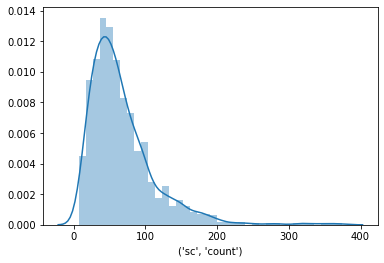

In [137]:
sns.distplot(df_vil['sc','count'])

In [138]:
df_vil.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1010 entries, (97, False, 3) to (98, True, 505)
Data columns (total 15 columns):
(sc, mean)                1010 non-null float64
(sc, count)               1010 non-null int64
(sc97, mean)              1010 non-null float64
(sc97, count)             1010 non-null int64
(folnum, count)           1010 non-null int64
(age, mean)               1010 non-null float64
(age, count)              1010 non-null int64
(sex, mean)               1010 non-null float64
(sex, count)              1010 non-null int64
(poor2, mean)             1010 non-null float64
(poor2, count)            1010 non-null int64
(attendance_count, )      1010 non-null float64
(attendance97_count, )    1010 non-null float64
(sc_diff, )               1010 non-null float64
(relative_sc_diff, )      1010 non-null float64
dtypes: float64(9), int64(6)
memory usage: 126.6 KB


establish specific grouping based on year and treatment:

In [139]:
df_treatment_98 = df_vil.loc[(98, True)]
df_control_98 = df_vil.loc[(98, False)]
df_treatment_97 = df_vil.loc[(97, True)]
df_control_97 = df_vil.loc[(97, False)]

Run through a series of tests to help isolate the treatment effect.
IE Assuming control and treatment have identical villages and that village characteristics haven't changed much in one year, there should be no difference between control 97 and treatment 98 and no difference between control 97 and control 98.
There should be statistical differences between treatment 97 and treatment 98 and treatment 98 and control 98 if the the treatment does have an effect (again assuming all else equal)

Test Village Aggregates by groups starting with Control 97 and 98:

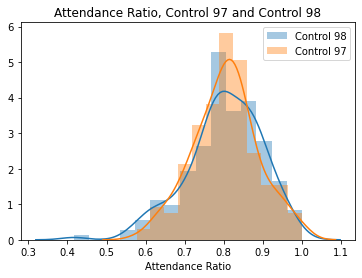

In [140]:
title='Attendance Ratio, Control 97 and Control 98'
fig = plt.figure()
ax = sns.distplot(df_control_98['sc','mean'], label='Control 98')
ax1 = sns.distplot(df_control_97['sc','mean'], label='Control 97')
ax.set(xlabel='Attendance Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
While control 98 is not quite normal enough for the shapiro test, the high shapiro statistic and the low skew and kurtosis suggest that it is approximately normal.
Control 97 passes the Shapiro test so it is normal enough.

In [141]:
print(stats.describe(df_control_98['sc','mean']))
print(stats.shapiro(df_control_98['sc','mean']))
print(stats.describe(df_control_97['sc','mean']))
print(stats.shapiro(df_control_97['sc','mean']))

DescribeResult(nobs=185, minmax=(0.4166666666666667, 1.0), mean=0.8013391827661084, variance=0.00927153719205734, skewness=-0.6606651220086096, kurtosis=0.7419502484482585)
(0.9728711843490601, 0.0011490960605442524)
DescribeResult(nobs=185, minmax=(0.5769230769230769, 1.0), mean=0.8041601616740699, variance=0.006955991208452856, skewness=-0.037236728777145636, kurtosis=-0.036990930489853024)
(0.9931789636611938, 0.5458758473396301)


Run both tests for consistency:
Neither test is statistically significant.  There is no statistical difference between the means.

In [142]:
print(stats.ttest_rel(df_control_98['sc','mean'],df_control_97['sc','mean']))
print(stats.wilcoxon(df_control_98['sc','mean']-df_control_97['sc','mean']))

Ttest_relResult(statistic=-0.5513860411605275, pvalue=0.5820380286733704)
WilcoxonResult(statistic=8118.0, pvalue=0.7695549526495411)


Test Village Aggregates for Treatment 97 and 98:

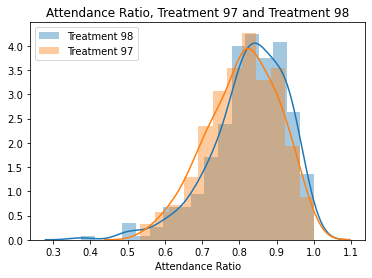

In [143]:
title='Attendance Ratio, Treatment 97 and Treatment 98'
fig = plt.figure()
ax = sns.distplot(df_treatment_98['sc','mean'], label='Treatment 98')
ax1 = sns.distplot(df_treatment_97['sc','mean'], label='Treatment 97')
ax.set(xlabel='Attendance Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
Both distributions fail the shapiro test, but are still close to normal.


In [144]:
print(stats.describe(df_treatment_98['sc','mean']))
print(stats.shapiro(df_treatment_98['sc','mean']))
print(stats.describe(df_treatment_97['sc','mean']))
print(stats.shapiro(df_treatment_97['sc','mean']))

DescribeResult(nobs=320, minmax=(0.375, 1.0), mean=0.8261356748827747, variance=0.010325172654044241, skewness=-0.9895284815764175, kurtosis=1.4354783117363379)
(0.9463104605674744, 2.1396995286693254e-09)
DescribeResult(nobs=320, minmax=(0.5344827586206896, 1.0), mean=0.8086905911970266, variance=0.009190212560015797, skewness=-0.3534393990738255, kurtosis=-0.372067621450749)
(0.98506098985672, 0.002112217713147402)


Run both tests for consistency:
There is a statistical difference between the mean for treatment 98 and treatment 97 regardless of normality assumptions.

In [145]:
print(stats.ttest_rel(df_treatment_98['sc','mean'],df_treatment_97['sc','mean']))
print(stats.wilcoxon(df_treatment_98['sc','mean']-df_treatment_97['sc','mean']))

Ttest_relResult(statistic=4.009557292695663, pvalue=7.580668163274759e-05)
WilcoxonResult(statistic=17760.0, pvalue=2.5135652457146823e-06)


In [146]:
get_95_ci(df_treatment_97['sc','mean'],df_treatment_98['sc','mean'])

(0.0021388039452362746, 0.032751363426259145)

There is a difference of approximately between .002 and .033.
Of a group of 100 students, potentially up to 3 more are enrolled after the program is initiated in treatment villages.

Test Control 97 and Treatment 97:

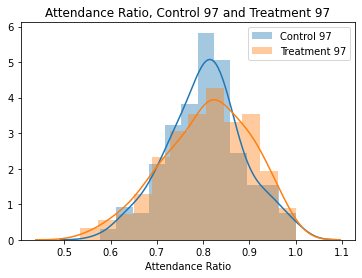

In [147]:
title='Attendance Ratio, Control 97 and Treatment 97'
fig = plt.figure()
ax = sns.distplot(df_control_97['sc','mean'], label='Control 97')
ax1 = sns.distplot(df_treatment_97['sc','mean'], label='Treatment 97')
ax.set(xlabel='Attendance Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
As mentioned above, treatment 97 is close to normal despite failing the shapiro test while control 97 passes the test.

In [148]:
print(stats.describe(df_treatment_97['sc','mean']))
print(stats.shapiro(df_treatment_97['sc','mean']))
print(stats.describe(df_control_97['sc','mean']))
print(stats.shapiro(df_control_97['sc','mean']))

DescribeResult(nobs=320, minmax=(0.5344827586206896, 1.0), mean=0.8086905911970266, variance=0.009190212560015797, skewness=-0.3534393990738255, kurtosis=-0.372067621450749)
(0.98506098985672, 0.002112217713147402)
DescribeResult(nobs=185, minmax=(0.5769230769230769, 1.0), mean=0.8041601616740699, variance=0.006955991208452856, skewness=-0.037236728777145636, kurtosis=-0.036990930489853024)
(0.9931789636611938, 0.5458758473396301)


Run both tests for consistency:
No statistical difference

In [149]:
print(stats.ttest_ind(df_treatment_97['sc','mean'],df_control_97['sc','mean']))
print(stats.kruskal(df_treatment_97['sc','mean'],df_control_97['sc','mean']))

Ttest_indResult(statistic=0.5360632049168287, pvalue=0.5921518374609)
KruskalResult(statistic=0.9587737963605347, pvalue=0.3274960123788197)


Test Control 98 and Treatment 98:

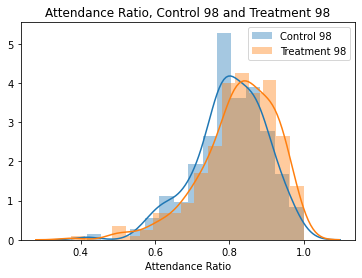

In [150]:
title='Attendance Ratio, Control 98 and Treatment 98'
fig = plt.figure()
ax = sns.distplot(df_control_98['sc','mean'], label='Control 98')
ax1 = sns.distplot(df_treatment_98['sc','mean'], label='Treatment 98')
ax.set(xlabel='Attendance Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
Again, control 98 is still close to normal, but treatment 98 is not particularly normal.

In [151]:
print(stats.describe(df_control_98['sc','mean']))
print(stats.shapiro(df_control_98['sc','mean']))
print(stats.describe(df_treatment_98['sc','mean']))
print(stats.shapiro(df_treatment_98['sc','mean']))

DescribeResult(nobs=185, minmax=(0.4166666666666667, 1.0), mean=0.8013391827661084, variance=0.00927153719205734, skewness=-0.6606651220086096, kurtosis=0.7419502484482585)
(0.9728711843490601, 0.0011490960605442524)
DescribeResult(nobs=320, minmax=(0.375, 1.0), mean=0.8261356748827747, variance=0.010325172654044241, skewness=-0.9895284815764175, kurtosis=1.4354783117363379)
(0.9463104605674744, 2.1396995286693254e-09)


Run both tests for consistency:
There is a statistical difference between the two distributions.

In [152]:
print(stats.ttest_ind(df_treatment_98['sc','mean'],df_control_98['sc','mean']))
print(stats.kruskal(df_treatment_98['sc','mean'],df_control_98['sc','mean']))

Ttest_indResult(statistic=2.6928845724754122, pvalue=0.007320046553386986)
KruskalResult(statistic=10.232885926817191, pvalue=0.0013795864171528493)


In [153]:
get_95_ci(df_control_98['sc','mean'],df_treatment_98['sc','mean'])

(0.00700658131767205, 0.042586402915660196)

There is a difference of approximately between .007 and .043.
Of a group of 100 students, potentially up to 4 more are enrolled in treatment villages in 98 than in 97.

Alternative treatment and control comparison:
Test Control 98 and Treatment 98:

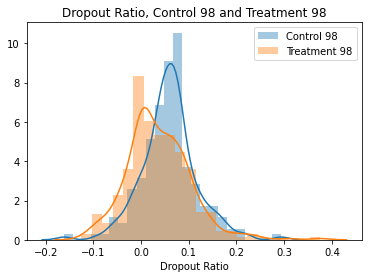

In [154]:
title='Dropout Ratio, Control 98 and Treatment 98'
fig = plt.figure()
ax = sns.distplot(df_control_98['relative_sc_diff'], label='Control 98')
ax1 = sns.distplot(df_treatment_98['relative_sc_diff'], label='Treatment 98')
ax.set(xlabel='Dropout Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
Both distributions have particularly high kurosis values making them not normal

In [155]:
print(stats.describe(df_control_98['relative_sc_diff']))
print(stats.shapiro(df_control_98['relative_sc_diff']))
print(stats.describe(df_treatment_98['relative_sc_diff']))
print(stats.shapiro(df_treatment_98['relative_sc_diff']))

DescribeResult(nobs=185, minmax=(-0.16129032258064516, 0.29411764705882354), mean=0.059018889642281386, variance=0.0034034492542756203, skewness=0.19766731273821642, kurtosis=2.0911734251858123)
(0.9707398414611816, 0.0006363921565935016)
DescribeResult(nobs=320, minmax=(-0.125, 0.375), mean=0.03693810627894754, variance=0.0045133863931289125, skewness=0.837653525217751, kurtosis=2.5158375619898647)
(0.9601488709449768, 1.163106162493932e-07)


Run both tests for consistency:
There is a statistical difference between the dropout rates for control 98 and treatment 98

In [156]:
print(stats.ttest_ind(df_treatment_98['relative_sc_diff'],df_control_98['relative_sc_diff']))
print(stats.kruskal(df_treatment_98['relative_sc_diff'],df_control_98['relative_sc_diff']))

Ttest_indResult(statistic=-3.730336053883459, pvalue=0.00021299845209728202)
KruskalResult(statistic=19.851026578129208, pvalue=8.371776200827596e-06)


In [157]:
get_95_ci(df_control_98['relative_sc_diff'],df_treatment_98['relative_sc_diff'])

(-0.03325473553753223, -0.010906831189135652)

There is a difference of approximately between -.03 and -.01.
Of a group of 100 students, about 1 student less drops out in the treatment villages than the control villages

#Take a look specifically at those eligible for welfare by village (ie the poor):

In [158]:
df_poor =df_drop_sc_null[df_drop_sc_null['poor2']]
df_vil_poor = df_poor.groupby([df_poor.year,df_poor.treatment,df_poor.village]).agg({'sc': ['mean','count'],'sc97': ['mean','count'],'folnum': ['count'],'age': ['mean','count'],'sex': ['mean','count'],'poor2': ['mean','count']})
df_vil_poor['attendance_count']=df_vil_poor['sc','mean']*df_vil_poor['sc','count']
df_vil_poor['attendance97_count']=df_vil_poor['sc97','mean']*df_vil_poor['sc97','count']
df_vil_poor['sc_diff']=df_vil_poor['attendance97_count']-df_vil_poor['attendance_count']
df_vil_poor['relative_sc_diff']=df_vil_poor['sc_diff']/df_vil_poor['sc','count']

In [159]:
df_vil_poor

sc            sc97       folnum        age  \
                            mean count      mean count  count       mean   
year treatment village                                                     
97   False     3        0.933333    15  0.933333    15     15   9.800000   
               13       0.742857    70  0.742857    70     70  10.900000   
               16       0.794118    34  0.794118    34     34   9.941176   
               20       0.959459    74  0.959459    74     74  10.364865   
               22       0.666667    96  0.666667    96     96  10.395833   
...                          ...   ...       ...   ...    ...        ...   
98   True      498      0.838710    31  0.935484    31     31  10.741935   
               499      0.848485    33  0.818182    33     33  10.848485   
               500      0.583333    12  0.750000    12     12  11.416667   
               501      0.795918    49  0.816327    49     49  10.979592   
               505      0.866667    45  0.888889    45     45  11.733333   

                                   sex       poor2       attendance_count  \
                       count      mean count  mean count                    
year treatment village                                                      
97   False     3          15  0.533333    15  True    15             14.0   
               13         70  0.600000    70  True    70             52.0   
               16         34  0.500000    34  True    34             27.0   
               20         74  0.567568    74  True    74             71.0   
               22         96  0.541667    96  True    96             64.0   
...                      ...       ...   ...   ...   ...              ...   
98   True      498        31  0.709677    31  True    31             26.0   
               499        33  0.545455    33  True    33             28.0   
               500        12  0.416667    12  True    12              7.0   
               501        49  0.387755    49  True    49             39.0   
               505        45  0.511111    45  True    45             39.0   

                       attendance97_count sc_diff relative_sc_diff  
                                                                    
year treatment village                                              
97   False     3                     14.0     0.0         0.000000  
               13                    52.0     0.0         0.000000  
               16                    27.0     0.0         0.000000  
               20                    71.0     0.0         0.000000  
               22                    64.0     0.0         0.000000  
...                                   ...     ...              ...  
98   True      498                   29.0     3.0         0.096774  
               499                   27.0    -1.0        -0.030303  
               500                    9.0     2.0         0.166667  
               501                   40.0     1.0         0.020408  
               505                   40.0     1.0         0.022222  

[1010 rows x 15 columns]

In [160]:
df_poor.head()

,year,sex,indig,dist_sec,sc,grc,fam_n,min_dist,dist_cap,poor,...,welfare_index,hohsex,hohage,age,village,folnum,grc97,sc97,treatment,poor2
0,97,0.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,583.0,1.0,35.0,13,163,1,7,1.0,False,True
1,98,0.0,0.0,4.473,1.0,8.0,7,21.168384,21.168384,pobre,...,583.0,1.0,35.0,14,163,1,7,1.0,False,True
2,97,1.0,0.0,4.473,1.0,6.0,7,21.168384,21.168384,pobre,...,583.0,1.0,35.0,12,163,2,6,1.0,False,True
3,98,1.0,0.0,4.473,1.0,7.0,7,21.168384,21.168384,pobre,...,583.0,1.0,35.0,13,163,2,6,1.0,False,True
4,97,0.0,0.0,4.473,1.0,2.0,7,21.168384,21.168384,pobre,...,583.0,1.0,35.0,8,163,3,2,1.0,False,True


In [161]:
df_vil_poor.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1010 entries, (97, False, 3) to (98, True, 505)
Data columns (total 15 columns):
(sc, mean)                1010 non-null float64
(sc, count)               1010 non-null int64
(sc97, mean)              1010 non-null float64
(sc97, count)             1010 non-null int64
(folnum, count)           1010 non-null int64
(age, mean)               1010 non-null float64
(age, count)              1010 non-null int64
(sex, mean)               1010 non-null float64
(sex, count)              1010 non-null int64
(poor2, mean)             1010 non-null bool
(poor2, count)            1010 non-null int64
(attendance_count, )      1010 non-null float64
(attendance97_count, )    1010 non-null float64
(sc_diff, )               1010 non-null float64
(relative_sc_diff, )      1010 non-null float64
dtypes: bool(1), float64(8), int64(6)
memory usage: 119.6 KB


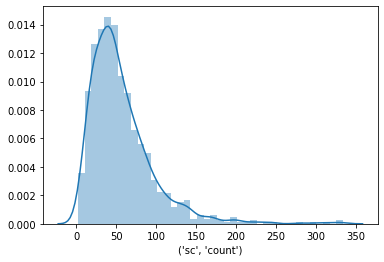

In [162]:
sns.distplot(df_vil_poor['sc','count'])

In [163]:
df_vil_poor['sc','count'].mean()

56.73069306930693

In [164]:
poor_treatment_98 = df_vil_poor.loc[(98, True)]
poor_control_98 = df_vil_poor.loc[(98, False)]
poor_treatment_97 = df_vil_poor.loc[(97, True)]
poor_control_97 = df_vil_poor.loc[(97, False)]

Control 97 and 98 for welfare eligible students:

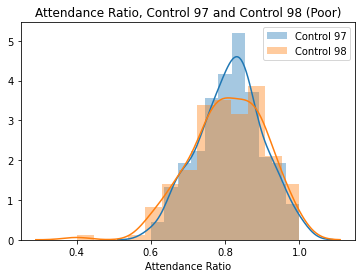

In [165]:

title='Attendance Ratio, Control 97 and Control 98 (Poor)'
fig = plt.figure()
ax = sns.distplot(poor_control_97['sc','mean'], label='Control 97')
ax1 = sns.distplot(poor_control_98['sc','mean'], label='Control 98')
ax.set(xlabel='Attendance Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
While control 97 is sufficiently normal, control 98 is less so, but arguably close enough.

In [166]:
print(stats.describe(poor_control_97['sc','mean']))
print(stats.shapiro(poor_control_97['sc','mean']))
print(stats.describe(poor_control_98['sc','mean']))
print(stats.shapiro(poor_control_98['sc','mean']))

DescribeResult(nobs=185, minmax=(0.6, 1.0), mean=0.8137762497441701, variance=0.007502661922755421, skewness=-0.11928930665265056, kurtosis=-0.3651952801548357)
(0.9901792407035828, 0.23574098944664001)
DescribeResult(nobs=185, minmax=(0.4, 1.0), mean=0.8080378111816627, variance=0.010061545290100792, skewness=-0.4921132302085343, kurtosis=0.5041724821784315)
(0.9795902967453003, 0.008275894448161125)


Run both tests for consistency:
There is no statistical difference between the two distibutions

In [167]:
print(stats.ttest_rel(poor_control_98['sc','mean'],poor_control_97['sc','mean']))
print(stats.wilcoxon(poor_control_98['sc','mean']-poor_control_97['sc','mean']))

Ttest_relResult(statistic=-1.0163849774375124, pvalue=0.3107806849628887)
WilcoxonResult(statistic=7533.0, pvalue=0.3819906041745612)


Treatment 97 and 98 for welfare eligible students:

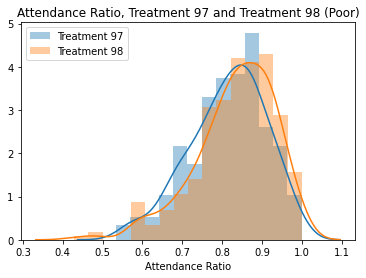

In [168]:
title='Attendance Ratio, Treatment 97 and Treatment 98 (Poor)'
fig = plt.figure()
ax = sns.distplot(poor_treatment_97['sc','mean'], label='Treatment 97')
ax1 = sns.distplot(poor_treatment_98['sc','mean'], label='Treatment 98')
ax.set(xlabel='Attendance Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
While the test show nonnormality, the statistics show the distributions to be approximately normal.

In [169]:
print(stats.describe(poor_treatment_97['sc','mean']))
print(stats.shapiro(poor_treatment_97['sc','mean']))
print(stats.describe(poor_treatment_98['sc','mean']))
print(stats.shapiro(poor_treatment_98['sc','mean']))

DescribeResult(nobs=320, minmax=(0.5333333333333333, 1.0), mean=0.8138394110596501, variance=0.009322450322173702, skewness=-0.4582004207729874, kurtosis=-0.1881270410278697)
(0.9803768992424011, 0.0002299641928402707)
DescribeResult(nobs=320, minmax=(0.42857142857142855, 1.0), mean=0.8336585039715774, variance=0.010049973815452607, skewness=-0.9214954527809902, kurtosis=1.0627422499031622)
(0.950221836566925, 6.1720042410229325e-09)


Run both tests for consistency:
There is a statistical difference between the two distibutions

In [170]:
print(stats.ttest_rel(poor_treatment_98['sc','mean'],poor_treatment_97['sc','mean']))
print(stats.wilcoxon(poor_treatment_98['sc','mean']-poor_treatment_97['sc','mean']))

Ttest_relResult(statistic=4.23702762838055, pvalue=2.9679997142036833e-05)
WilcoxonResult(statistic=17466.5, pvalue=1.033991817025518e-06)


In [171]:
get_95_ci(poor_treatment_97['sc','mean'],poor_treatment_98['sc','mean'])

(0.004568979739487862, 0.03506920608436628)

There is a difference of approximately between .004 and .035.
Of a group of 100 poor students, up to 3 student more are attending in 98 than 97

Test Control 97 and Treatment 97 (poor):

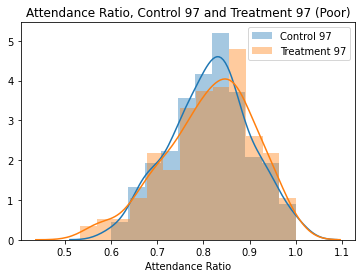

In [172]:
title='Attendance Ratio, Control 97 and Treatment 97 (Poor)'
fig = plt.figure()
ax = sns.distplot(poor_control_97['sc','mean'], label='Control 97')
ax1 = sns.distplot(poor_treatment_97['sc','mean'], label='Treatment 97')
ax.set(xlabel='Attendance Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
While poor control 97 passes the shapiro test, poor treatment 97 is questionable at best.

In [173]:
print(stats.describe(poor_treatment_97['sc','mean']))
print(stats.shapiro(poor_treatment_97['sc','mean']))
print(stats.describe(poor_control_97['sc','mean']))
print(stats.shapiro(poor_control_97['sc','mean']))

DescribeResult(nobs=320, minmax=(0.5333333333333333, 1.0), mean=0.8138394110596501, variance=0.009322450322173702, skewness=-0.4582004207729874, kurtosis=-0.1881270410278697)
(0.9803768992424011, 0.0002299641928402707)
DescribeResult(nobs=185, minmax=(0.6, 1.0), mean=0.8137762497441701, variance=0.007502661922755421, skewness=-0.11928930665265056, kurtosis=-0.3651952801548357)
(0.9901792407035828, 0.23574098944664001)


Run both tests for consistency:
There is no statistical difference between the two distibutions

In [174]:
print(stats.ttest_ind(poor_treatment_97['sc','mean'],poor_control_97['sc','mean']))
print(stats.kruskal(poor_treatment_97['sc','mean'],poor_control_97['sc','mean']))

Ttest_indResult(statistic=0.007350021070489146, pvalue=0.9941384985665984)
KruskalResult(statistic=0.26708392197095704, pvalue=0.6052946439667392)


Test Control 98 and Treatment 98 (poor):

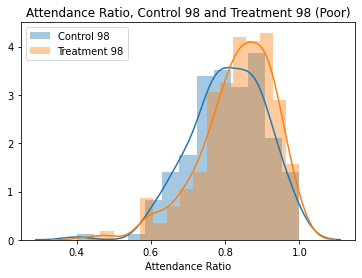

In [175]:
title='Attendance Ratio, Control 98 and Treatment 98 (Poor)'
fig = plt.figure()
ax = sns.distplot(poor_control_98['sc','mean'], label='Control 98')
ax1 = sns.distplot(poor_treatment_98['sc','mean'], label='Treatment 98')
ax.set(xlabel='Attendance Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:
Normality is not supported by the tests, but the descriptive stats show approximate normality.

In [176]:
print(stats.describe(poor_control_98['sc','mean']))
print(stats.shapiro(poor_control_98['sc','mean']))
print(stats.describe(poor_treatment_98['sc','mean']))
print(stats.shapiro(poor_treatment_98['sc','mean']))

DescribeResult(nobs=185, minmax=(0.4, 1.0), mean=0.8080378111816627, variance=0.010061545290100792, skewness=-0.4921132302085343, kurtosis=0.5041724821784315)
(0.9795902967453003, 0.008275894448161125)
DescribeResult(nobs=320, minmax=(0.42857142857142855, 1.0), mean=0.8336585039715774, variance=0.010049973815452607, skewness=-0.9214954527809902, kurtosis=1.0627422499031622)
(0.950221836566925, 6.1720042410229325e-09)


Run both tests for consistency:
There is a statistical difference between the two distibutions

In [177]:
print(stats.ttest_ind(poor_treatment_98['sc','mean'],poor_control_98['sc','mean']))
print(stats.kruskal(poor_treatment_98['sc','mean'],poor_control_98['sc','mean']))

Ttest_indResult(statistic=2.766509259450196, pvalue=0.005874531499028336)
KruskalResult(statistic=10.057726616945176, pvalue=0.0015171031789141382)


In [178]:
get_95_ci(poor_control_98['sc','mean'],poor_treatment_98['sc','mean'])

(0.007466299310420508, 0.043775086269408764)

The village average for poor students is between ~.01 and .04 higher in treatment 98 villages than control 98 villages.
Up to 4 more students in a village sample of 100.

Dropouts for Poor:

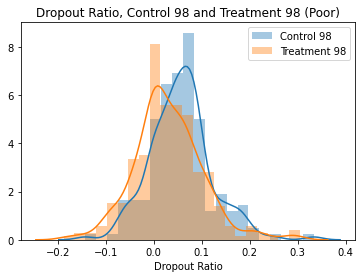

In [179]:
title='Dropout Ratio, Control 98 and Treatment 98 (Poor)'
fig = plt.figure()
ax = sns.distplot(poor_control_98['relative_sc_diff'], label='Control 98')
ax1 = sns.distplot(poor_treatment_98['relative_sc_diff'], label='Treatment 98')
ax.set(xlabel='Dropout Ratio',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for Normality:

In [180]:
print(stats.describe(poor_control_98['relative_sc_diff']))
print(stats.shapiro(poor_control_98['relative_sc_diff']))
print(stats.describe(poor_treatment_98['relative_sc_diff']))
print(stats.shapiro(poor_treatment_98['relative_sc_diff']))

DescribeResult(nobs=185, minmax=(-0.14285714285714285, 0.3333333333333333), mean=0.05643699545236023, variance=0.004264038531789995, skewness=0.4893324935006219, kurtosis=1.6734835668700114)
(0.9733818173408508, 0.0013271690113469958)
DescribeResult(nobs=320, minmax=(-0.1875, 0.30434782608695654), mean=0.030491383487455326, variance=0.005212691642705614, skewness=0.4723184414597238, kurtosis=1.433893553781889)
(0.976091206073761, 3.620921415858902e-05)


Ran both tests for consistency:
There is a statistical difference between the means

In [181]:
print(stats.ttest_ind(poor_treatment_98['relative_sc_diff'],poor_control_98['relative_sc_diff']))
print(stats.kruskal(poor_treatment_98['relative_sc_diff'],poor_control_98['relative_sc_diff']))

Ttest_indResult(statistic=-4.027242513907709, pvalue=6.514520256709966e-05)
KruskalResult(statistic=19.759510620654574, pvalue=8.782357435316305e-06)


In [182]:
get_95_ci(poor_control_98['relative_sc_diff'],poor_treatment_98['relative_sc_diff'])


(-0.03823881545087919, -0.013652408478930667)

The dropout rate is ~.014-.038 between the two distributions
A treatment village has up to a ~.04 smaller dropout rate among poor students (up to ~4 more kids out of 100)

#Test Treatment 97 and Treatment 98 (poor):

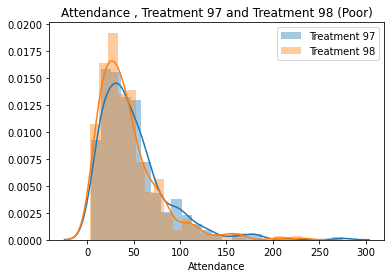

In [183]:
title='Attendance , Treatment 97 and Treatment 98 (Poor)'
fig = plt.figure()
ax = sns.distplot(poor_treatment_97['attendance_count'], label='Treatment 97')
ax1 = sns.distplot(poor_treatment_98['attendance_count'], label='Treatment 98')
ax.set(xlabel='Attendance',title=title)
plt.legend()
fig.savefig(title+'plot.png')

Test for normality:
Results are significant (not normal)

In [184]:
print(stats.describe(poor_treatment_97['attendance_count']))
print(stats.shapiro(poor_treatment_97['attendance_count']))
print(stats.describe(poor_treatment_98['attendance_count']))
print(stats.shapiro(poor_treatment_98['attendance_count']))

DescribeResult(nobs=320, minmax=(4.0, 275.0), mean=49.228125, variance=1356.3521845611283, skewness=2.0008780885274997, kurtosis=6.3202066536138055)
(0.8404898643493652, 1.6289512293051614e-17)
DescribeResult(nobs=320, minmax=(3.0, 231.0), mean=43.5125, variance=1110.7271159874608, skewness=1.9527897661640747, kurtosis=5.569190595221299)
(0.8387312293052673, 1.3057849161524331e-17)


In [185]:
print(stats.kruskal(poor_treatment_97['attendance_count'],poor_treatment_98['attendance_count']))

KruskalResult(statistic=5.182052987395617, pvalue=0.02282134381843465)


Only the Kurskal-Wallis test is used because normality is clearly inappropriate to assume
Results are significant

In [186]:
get_95_ci(poor_treatment_97['attendance_count'],poor_treatment_98['attendance_count'])

(-11.15780167878265, -0.27344832121734175)

Villages on average have between 0 and 11 more poor students in 97 than 98.
Confidence Intervals are not particularly meaningful due to the non normality of the distributions and the wide variations in sample sizes by village

Look at individual cases

Analyzing at the village level gives greater weight to smaller villages with fewer cases despite helping minimize variance in other characteristics.

With the tools available, the best approach is to calculate crosstabs for years 97 and 98 and compare the 2 crosstabs to each other with a chisquare test

Default tests to say the categories are different do not explain much

In [187]:
cross97 = pd.crosstab(index=df['sc'][df['year']==97],columns=df['treatment'][df['year']==97],margins=True)
print('YEAR 97')
print(cross97)
cross_norm97 = pd.crosstab(index=df['sc'][df['year']==97],columns=df['treatment'][df['year']==97],margins=True,normalize=True)
print(cross_norm97)

YEAR 97
treatment  False   True    All
sc                            
0.0         2723   4104   6827
1.0        11355  18507  29862
All        14078  22611  36689
treatment     False      True       All
sc                                     
0.0        0.074218  0.111859  0.186078
1.0        0.309493  0.504429  0.813922
All        0.383712  0.616288  1.000000


In [188]:
cross98 = pd.crosstab(index=df['sc'][df['year']==98],columns=df['treatment'][df['year']==98],margins=True)
print('YEAR 98')
print(cross98)
cross_norm98 = pd.crosstab(index=df['sc'][df['year']==98],columns=df['treatment'][df['year']==98],margins=True,normalize=True)
print(cross_norm98)

YEAR 98
treatment  False   True    All
sc                            
0.0         2419   3150   5569
1.0         9855  16684  26539
All        12274  19834  32108
treatment     False      True       All
sc                                     
0.0        0.075339  0.098106  0.173446
1.0        0.306933  0.519621  0.826554
All        0.382272  0.617728  1.000000


In [189]:
cross97

treatment,False,True,All
sc,,,
0.0,2723,4104,6827
1.0,11355,18507,29862
All,14078,22611,36689


In [190]:
expected_freq = cross_norm97 * df['sc'][df['year']==98].count()
print(expected_freq)

treatment         False          True           All
sc                                                 
0.0         2383.005369   3591.573278   5974.578648
1.0         9937.211153  16196.210199  26133.421352
All        12320.216523  19787.783477  32108.000000


In [191]:
cross_diff =cross98-expected_freq
print(cross_diff)

treatment      False        True         All
sc                                          
0.0        35.994631 -441.573278 -405.578648
1.0       -82.211153  487.789801  405.578648
All       -46.216523   46.216523    0.000000


In [192]:
relative_diff = cross_diff/cross98
print(relative_diff)

treatment     False      True       All
sc                                     
0.0        0.014880 -0.140182 -0.072828
1.0       -0.008342  0.029237  0.015282
All       -0.003765  0.002330  0.000000


In [193]:
cross_diff

treatment,False,True,All
sc,,,
0.0,35.994631,-441.573278,-405.578648
1.0,-82.211153,487.789801,405.578648
All,-46.216523,46.216523,0.000000


In [194]:
stats.chisquare(f_obs=cross98,f_exp=expected_freq)

Power_divergenceResult(statistic=array([ 1.39719761, 69.08909066, 33.82671828]), pvalue=array([4.97281603e-01, 9.94247672e-16, 4.51462263e-08]))

the statistically significant results show that there is a statistical difference in school attendance between 97 and 98 (accounting for difference in population size).  Looking at the 2 charts above, one can see a particularly pronounced effect for the treatment (True) column.  non-attendance dropped by ~14%, while attendence grew at a modest ~3%.  With slight opposite trends for the control group, this lends strong, but not exhaustive, evidence of the impact of the welfare program.

Look at poor (not using earlier df_poor to remove only necessary nulls):

In [195]:
#Look at poor (not using earlier df_poor to remove only necessary nulls)
df_poor2 = df[df['poor2']==True]

In [196]:
poor_cross97 = pd.crosstab(index=df_poor2['sc'][df_poor2['year']==97],columns=df_poor2['treatment'][df_poor2['year']==97],margins=True)
print('YEAR 97')
print(poor_cross97)
poor_cross_norm97 = pd.crosstab(index=df_poor2['sc'][df_poor2['year']==97],columns=df_poor2['treatment'][df_poor2['year']==97],margins=True,normalize=True)
print(poor_cross_norm97)

YEAR 97
treatment  False   True    All
sc                            
0.0         2176   3395   5571
1.0         9598  15753  25351
All        11774  19148  30922
treatment     False      True       All
sc                                     
0.0        0.070371  0.109792  0.180163
1.0        0.310394  0.509443  0.819837
All        0.380765  0.619235  1.000000


In [197]:
poor_cross98 = pd.crosstab(index=df_poor2['sc'][df_poor2['year']==98],columns=df_poor2['treatment'][df_poor2['year']==98],margins=True)
print('YEAR 98')
print(poor_cross98)
poor_cross_norm98 = pd.crosstab(index=df_poor2['sc'][df_poor2['year']==98],columns=df_poor2['treatment'][df_poor2['year']==98],margins=True,normalize=True)
print(poor_cross_norm98)

YEAR 98
treatment  False   True    All
sc                            
0.0         2005   2614   4619
1.0         8418  14413  22831
All        10423  17027  27450
treatment     False      True      All
sc                                    
0.0        0.073042  0.095228  0.16827
1.0        0.306667  0.525064  0.83173
All        0.379709  0.620291  1.00000


In [198]:
poor_expected_freq = poor_cross_norm97 * df_poor2['sc'][df_poor2['year']==98].count()
print(poor_expected_freq)

treatment         False          True           All
sc                                                 
0.0         1931.673242   3013.800854   4945.474096
1.0         8520.312399  13984.213505  22504.525904
All        10451.985641  16998.014359  27450.000000


In [199]:
poor_cross_diff =poor_cross98-poor_expected_freq
print(poor_cross_diff)

treatment       False        True         All
sc                                           
0.0         73.326758 -399.800854 -326.474096
1.0       -102.312399  428.786495  326.474096
All        -28.985641   28.985641    0.000000


In [200]:
poor_relative_diff = poor_cross_diff/poor_cross98
print(poor_relative_diff)

treatment     False      True       All
sc                                     
0.0        0.036572 -0.152946 -0.070681
1.0       -0.012154  0.029750  0.014300
All       -0.002781  0.001702  0.000000


In [201]:
poor_cross_diff

treatment,False,True,All
sc,,,
0.0,73.326758,-399.800854,-326.474096
1.0,-102.312399,428.786495,326.474096
All,-28.985641,28.985641,0.000000


In [202]:
stats.chisquare(f_obs=poor_cross98,f_exp=poor_expected_freq)

Power_divergenceResult(statistic=array([ 4.09245714, 66.2332158 , 26.28826993]), pvalue=array([1.29221335e-01, 4.14610150e-15, 1.95692741e-06]))

When specifically looking at the poor (those eligble for welfare), we see a similar result where the treatment group in 98 has about ~15% fewer non-attendance and ~3% more attendance while the control group has ~3-4% more non-attendance and ~1% less attendance.  While the numbers are only slightly more pronounced than the larger population, this additional test helps reinforce that there are statistical differences between the treatment and control group in regards to attendance and that there are differences between treatment 97 and treatment 98 given the particularly high reduction in non-attendance.

Look at Treatment 97 and Treatment 98:

C:\Users\Public\Anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Public\Anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


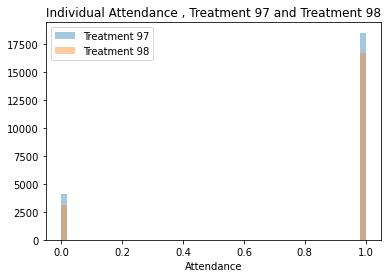

In [203]:
title='Individual Attendance , Treatment 97 and Treatment 98'
fig = plt.figure()
ax = sns.distplot(treatment_pop_97['sc'], label='Treatment 97',kde=False)
ax1 = sns.distplot(treatment_pop_98['sc'], label='Treatment 98',kde=False)
ax.set(xlabel='Attendance',title=title)
plt.legend()
fig.savefig(title+'plot.png')

No need to run normality tests:

In [204]:
print(treatment_pop_97['sc'].mean())
print(treatment_pop_98['sc'].mean())

0.8184954225819292
0.841181809014823


In [205]:
stats.wilcoxon(treatment_pop_98['sc']-treatment_pop_98['sc97'])

C:\Users\Public\Anaconda\lib\site-packages\scipy\stats\morestats.py:2882: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
C:\Users\Public\Anaconda\lib\site-packages\scipy\stats\morestats.py:2883: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


WilcoxonResult(statistic=599027.0, pvalue=0.0)

Note that sc97 is approximately treatment_pop_97['sc'], but is directly paired with treatment_pop_98
Given that the statistic and p value are very high and very low, I interpret this as an inappopriate model despite the non normality and paired data (too large a sample).

With many different tests done here, there are a few points to reemphasize.  On a consistent basis, regardless of the unit of analysis (individual/village) or whether by attendance or dropouts, the treatment difference (treatment 97 to 98 or control 98 to treatment 98) is consistently show to be significance although the magnitude is debateable.  While controls should be accounted for more explicitly than the tests done here, the ttests for many control variable, while not a perfect tool, do support the experiment designers' goal of creating relatively similar treatment and control groups.  Without using a regression or probit model, I believe that this is about as strong a case one can make that there is a treatment effect and that it is primarily caused by the welfare program.  That being said, I am fully aware that the tests do not formally show causality or address confounding variables.  